In [2]:
import math
import os
from collections import defaultdict
from PIL import Image
from dataclasses import dataclass

import pandas as pd
import spacy

import numpy as np
import matplotlib.pyplot as plt
from tqdm  import tqdm, trange


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data.dataloader as dataloader
from torch.utils.data import DataLoader, Dataset

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.meteor_score import meteor_score
from torch.utils.tensorboard import SummaryWriter

from transformers import GPT2LMHeadModel, GPT2Tokenizer
from transformers import ViTFeatureExtractor, ViTModel

In [3]:
class Vocabulary():
    max_len = 45

    
    def __init__(self, model_name = "gpt2"):
        self.tokenizer = GPT2Tokenizer.from_pretrained(model_name)
        self.tokenizer.pad_token = self.tokenizer.eos_token
        
    
    def __len__(self):
        return self.tokenizer.vocab_size

    def vocab_size(self):
        return self.tokenizer.vocab_size
    
    def encode(self, text, with_attention_mask: bool = False, padding = False):
        max_seq = None
        if padding:
            max_seq = Vocabulary.max_len
            padding = 'max_length'
        return self.tokenizer(text, padding=padding, max_length=max_seq, return_attention_mask=with_attention_mask)
    
    def decode(self, text, skip_special_tokens=True):
        return self.tokenizer.decode(text, skip_special_tokens=skip_special_tokens)

In [4]:
class FlickrDataset(Dataset):
    max_len = 45
    def __init__(self, root_dir, data_dict, vocabulary: Vocabulary, transform=None, train=True):
        self.root_dir = root_dir
        self.data_dict = data_dict
        self.transform = transform

        # get the image and caption
        self.train = train
        self.caption = []
        self.item = self.setup_item()

        # Create our own vocabulary
        self.vocabulary = vocabulary
        self.eos_token = vocabulary.tokenizer.eos_token
        self.pad_token = vocabulary.tokenizer.pad_token
    
    def __len__(self):
        return len(self.item)
    
    def setup_item(self):
        item = []
        if self.train:
            for image_id, image_captions in self.data_dict.items():
                for caption in image_captions:
                    item.append((image_id, caption))
        else:
            for image_id, image_captions in self.data_dict.items():
                item.append((image_id, image_captions))
        return item


    def __getitem__(self, index):
        # get image
        image_path = os.path.join(self.root_dir, self.item[index][0])
        img = Image.open(image_path).convert('RGB')

        if self.transform is not None:
            img = self.transform(img)
        
        # get caption
        caption = self.item[index][1]
        
        if self.train:
            caption += self.eos_token
            caption = self.vocabulary.encode(caption, True, True)
            return img, torch.tensor(caption.input_ids, dtype=torch.long), torch.tensor(caption.attention_mask, dtype=torch.long)
        else:
            captions = torch.zeros(5, self.vocabulary.max_len).to(torch.long)
            atten_mask = torch.zeros(5, self.vocabulary.max_len).to(torch.long)
            for idx, cap in enumerate(caption):
                cap += self.eos_token
                cap = self.vocabulary.encode(cap,True, True)
                captions[idx] = torch.tensor(cap.input_ids, dtype=torch.long)
                atten_mask[idx] = torch.tensor(cap.attention_mask, dtype=torch.long)
            return img, captions, atten_mask

In [5]:
def train_val_split(caption_data, train_size=0.8, shuffle=True):
    """Split the captioning dataset into train and validation sets.

    Args:
        caption_data (dict): Dictionary containing the mapped caption data
        train_size (float): Fraction of all the full dataset to use as training data
        shuffle (bool): Whether to shuffle the dataset before splitting

    Returns:
        Traning and validation datasets as two separated dicts
    """

    # 1. Get the list of all image names
    all_images = list(caption_data.keys())

    # 2. Shuffle if necessary
    if shuffle:
        np.random.shuffle(all_images)

    # 3. Split into training and validation sets
    train_size = int(len(caption_data) * train_size)

    training_data = {
        img_name: caption_data[img_name] for img_name in all_images[:train_size]
    }
    validation_data = {
        img_name: caption_data[img_name] for img_name in all_images[train_size:]
    }

    # 4. Return the splits
    return training_data, validation_data

df = pd.read_csv("data/captions.txt")
data_dict = {}
caption_dict = defaultdict(list)
for _, row in df.iterrows():
    caption_dict[row.image].append(row.caption)
train_data, val_data = train_val_split(caption_dict)

In [6]:
folder = "data/images/"

In [7]:
vocab = Vocabulary()
vocab.vocab_size()

50257

In [8]:
image_size = 256
train_transform = transforms.Compose([transforms.Resize(image_size),
                                      transforms.CenterCrop(224),
                                      #transforms.RandomHorizontalFlip(0.1),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                                           std=[0.5, 0.5, 0.5])]) 

val_transform = transforms.Compose([transforms.Resize(image_size),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                                    std=[0.5, 0.5, 0.5])]) 

In [9]:
train_dataset = FlickrDataset(root_dir=folder, data_dict=train_data,vocabulary=vocab,
                        transform=train_transform, train=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Random Shape: torch.Size([3, 224, 224])
Random Caption: torch.Size([45])
A big dog and a smaller dog fight over a piece of fabric .


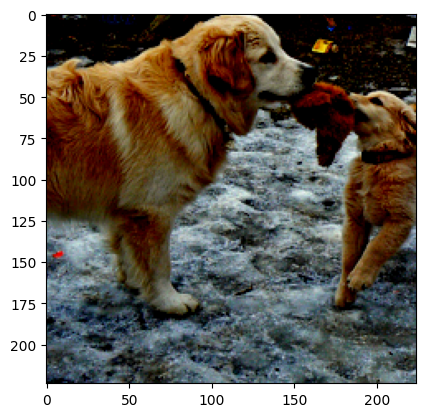

In [10]:
import random
random_index = random.randint(0, len(train_dataset) - 1)

# Get the random element
random_image, random_label, _ = train_dataset[random_index]

print("Random Shape:", random_image.shape)
print("Random Caption:", random_label.shape)
plt.imshow(random_image.permute(1, 2,0))
print(vocab.decode(random_label.tolist()))

In [11]:
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
for image, caption, _ in train_loader:
    print("Full Batch Caption", caption.shape)
    print("Full Batch Image Shape", image.shape)
    index = random.randint(0, 31)
    first_image = image[index]
    print(first_image.shape)
    first_caption = caption[index]
    print(first_caption.shape)
    break

Full Batch Caption torch.Size([32, 45])
Full Batch Image Shape torch.Size([32, 3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([45])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Random Shape: torch.Size([3, 224, 224])
Random Caption: torch.Size([5, 45])


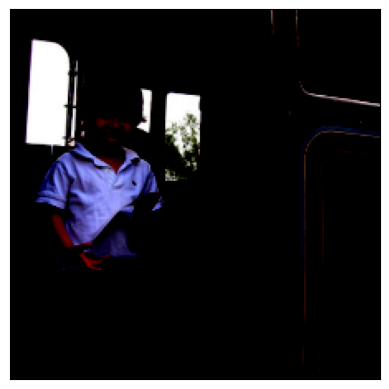

a boy in a white shirt and jeans in what looks like a black camper
A child in a white shirt and jeans .
A little boy in a white shirt and jeans stands in an R.V.
A little boy stands in the doorway of a van .
A small boy in jeans and a white shirt holding a piece of paper in a black vehicle .


In [12]:
val_dataset = FlickrDataset(root_dir=folder, data_dict=val_data,vocabulary=vocab,
                        transform=val_transform, train=False)
random_index = random.randint(0, len(val_dataset) - 1)

# Get the random element
random_image, random_label, _ = val_dataset[random_index]

print("Random Shape:", random_image.shape)
print("Random Caption:", random_label.shape)
plt.xticks([])
plt.yticks([])
plt.imshow(random_image.permute(1, 2,0))
plt.show()
print(vocab.decode(random_label[0].tolist()))
print(vocab.decode(random_label[1].tolist()))
print(vocab.decode(random_label[2].tolist()))
print(vocab.decode(random_label[3].tolist()))
print(vocab.decode(random_label[4].tolist()))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([32, 5, 45])
torch.Size([32, 5, 45])
torch.Size([32, 3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([5, 45])


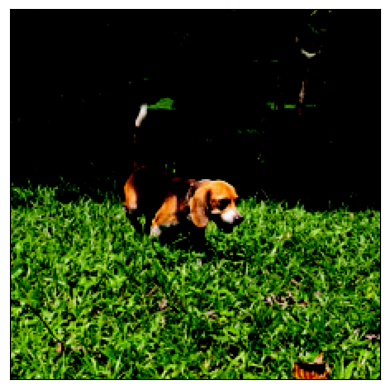

A beagle walks through the grass .
A black and tan dog standing in a field near trees
A brown and tan dog walks through the green grass .
a smal hound dog walking through the grass outside .
The dog is walking through a grassy area .


In [13]:
val_loader = DataLoader(dataset=val_dataset, batch_size=32, shuffle=True)
for image, caption, att_mask in val_loader:
    print(caption.shape)
    print(att_mask.shape)
    print(image.shape)
    index = random.randint(0, 31)
    random_image = image[index]
    print(random_image.shape)
    random_label = caption[index]
    print(random_label.shape)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(random_image.permute(1, 2,0))
    plt.show()
    print(vocab.decode(random_label[0].tolist()))
    print(vocab.decode(random_label[1].tolist()))
    print(vocab.decode(random_label[2].tolist()))
    print(vocab.decode(random_label[3].tolist()))
    print(vocab.decode(random_label[4].tolist()))
    break

## Model Implementation

In [14]:
vit_name = "google/vit-base-patch16-224-in21k"
vit_name = "google/vit-base-patch16-224"
vit = ViTModel.from_pretrained(vit_name)

vit.eval()
image = Image.open("./data/images/10815824_2997e03d76.jpg")
image = val_transform(image)

with torch.no_grad():
    outputs = vit(image.unsqueeze(0))



Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
vit

ViTModel(
  (embeddings): ViTEmbeddings(
    (patch_embeddings): ViTPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): ViTEncoder(
    (layer): ModuleList(
      (0-11): 12 x ViTLayer(
        (attention): ViTAttention(
          (attention): ViTSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
          )
          (output): ViTSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (intermediate): ViTIntermediate(
          (dense): Linear(in_features=768, out_features=3072, bias=True)
          (intermediate_act_fn): GELUActivation()
        )
        (output): ViTOutput(
          (d

In [16]:
outputs.keys()

odict_keys(['last_hidden_state', 'pooler_output'])

In [17]:
outputs.pooler_output.shape

torch.Size([1, 768])

In [79]:

@dataclass
class GPTConfig:
    
    block_size: int = 1024 # max sequence length
    vocab_size: int = 50257 # size of vocabulary
    n_layer: int = 12 # number of layers
    n_head: int = 12 # number of attention heads
    n_embed: int = 768 # embedding dimension

class CasualSelfAttention(nn.Module):
    
    def __init__(self, config: GPTConfig):
        super().__init__()
        assert config.n_embed % config.n_head == 0
        self.config = config
        # we will use this to get the key, value, pair for all heads only using one batch
        self.c_attn = nn.Linear(config.n_embed, 3*config.n_embed)
        
        # output
        self.c_proj = nn.Linear(config.n_embed, config.n_embed)
        self.c_proj.NANOGPT_SCALE_INIT = 1
        #regularization
        self.n_head = config.n_head
        self.n_embed = config.n_embed
        
        # not really a bias, used for masking
        self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size)).view(1, 1, config.block_size, config.block_size).type(torch.int)
                             , persistent=False)
        
    
    def forward(self, x, att_mask=None):
        # x of shape (batch_size, seq_len, embed_dim)
        # att_mask of shape (batch_size, seq_len)
        batch_size, seq_len, embed_dim = x.size()
        
        qkv = self.c_attn(x)
        q, k, v = qkv.split(self.n_embed, dim=2) # split on last dimention
        
        q = q.view(batch_size, seq_len, self.n_head, embed_dim // self.n_head).transpose(1, 2) #(b, nh, seq_len, hs)
        k = k.view(batch_size, seq_len, self.n_head, embed_dim // self.n_head).transpose(1, 2) #(b, nh, seq_len, hs)
        v = v.view(batch_size, seq_len, self.n_head, embed_dim // self.n_head).transpose(1, 2) #(b, nh, seq_len, hs)
        
        att = (q @ k.transpose(-2, -1)) * (1/ math.sqrt(k.size(-1)))  #(batch_size, h, seq_len, seq_len)
        
        mask = self.bias[:,:, :seq_len,:seq_len]
        if att_mask is not None:
            mask = self.bias[:,:, :seq_len,:seq_len] & att_mask.unsqueeze(1).unsqueeze(1).int() # batch_size, 1, seq_len, seq_len
            
        att = att.masked_fill(mask == 0, float("-inf"))
        att = F.softmax(att, dim=-1)
        y = att @ v # (b, nh, seq_len, seq_len) x (b, nh, seq_len, hs) -> (b, nh, seq_len, hs)
        y = y.transpose(1, 2).contiguous().view(batch_size, seq_len, embed_dim)
        return self.c_proj(y)
    
class MLP(nn.Module):
    
    def __init__(self, config: GPTConfig):
        super().__init__()
        
        self.config = config
        self.c_fc = nn.Linear(config.n_embed, 4*config.n_embed)
        self.gelu = nn.GELU(approximate="tanh")
        self.c_proj = nn.Linear(4 * config.n_embed, config.n_embed)
        self.c_proj.NANOGPT_SCALE_INIT = 1
    
    def forward(self, x):
        return self.c_proj(self.gelu(self.c_fc(x)))

class Block(nn.Module):
    
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.config = config
        self.ln_1 = nn.LayerNorm(config.n_embed)
        self.attn = CasualSelfAttention(config)
        self.ln_2 = nn.LayerNorm(config.n_embed)
        self.mlp = MLP(config)
    
    def forward(self, x, att_mask = None):
        x = x + self.attn(self.ln_1(x), att_mask)
        x = x + self.mlp(self.ln_2(x))
        return x
    
class GPT(nn.Module):
    
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.config = config
        
        self.transformer = nn.ModuleDict(
            dict(
                wte = nn.Embedding(config.vocab_size, config.n_embed), # typical(token) embedding 
                wpe = nn.Embedding(config.block_size, config.n_embed), # positional emebeding
                h = nn.ModuleList(Block(config) for _ in range(config.n_layer)),
                ln_f = nn.LayerNorm(config.n_embed)
            )
        )
        self.lm_head = nn.Linear(config.n_embed, config.vocab_size, bias=False)
        
        # weight sharing scheme
        self.transformer.wte.weight = self.lm_head.weight
        
        
        self.apply(self._init_weights)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            std = 0.02
            if hasattr(module, 'NANOGPT_SCALE_INIT'):
                std *= (2 * self.config.n_layer) ** -0.5 # std deviation initialization to get the to finish with std of 1. We multiply by two because each layer has 2 residual blocks
            torch.nn.init.normal_(module.weight, mean=0.0, std=std)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            
        
    
    def forward(self, idx: torch.Tensor, encoder_output: torch.Tensor, attn_mask: torch.Tensor = None):
        # we get idx of shape batch_size, seq_len
        # encoder output of shape batch_size, n_embed
        # attn_mask is of shape batch_size, seq_len
        batch_size, seq_len = idx.shape
        assert seq_len <= self.config.block_size, f"Cannot process a sequence length of {seq_len}, the context length is of size {self.config.block_size}, which is smaller"
        seq_len += 1
        
        token_embed = self.transformer.wte(idx) # shape( batch_size, seq_len, n_embed)
        token_embed = torch.cat([encoder_output.unsqueeze(1), token_embed], dim=1)
        
        pos = torch.arange(0, seq_len, dtype=torch.long, device=idx.device)
        pos_embed = self.transformer.wpe(pos) # shape (seq_len, n_emebd)
        x = pos_embed + token_embed # broadcasting occurs resulting in output of shape batch_size, seq_len, n_embed
        
        if attn_mask is not None:
            cls_attention = torch.ones((batch_size, 1), device=attn_mask.device)
            attn_mask = torch.cat([cls_attention, attn_mask], dim=1) # now attn_mask matches the new seq_len.
        
        # go forward in the decoder layer
        for block in self.transformer.h:
            x = block(x, attn_mask)
            
        # last layer normalization
        x = self.transformer.ln_f(x)
        
        logits = self.lm_head(x) # result of shape batch_size, seq_len, vocab_size
        return logits
    
    @classmethod
    def from_pretrained(cls, model_type):
        """Load pretrained GPT-2 model weight from hugging face"""
        assert model_type in {"gpt2", "gpt2-medium", "gpt2-large", "gpt2-xl"}
        
        from transformers import GPT2LMHeadModel
        print("Loading weights from pretrained gpt: ", model_type)
        
        # n_layer, n_head and n_embd are determined from model_type
        config_args = {
            'gpt2':         dict(n_layer=12, n_head=12, n_embed=768),  # 124M params
            'gpt2-medium':  dict(n_layer=24, n_head=16, n_embed=1024), # 350M params
            'gpt2-large':   dict(n_layer=36, n_head=20, n_embed=1280), # 774M params
            'gpt2-xl':      dict(n_layer=48, n_head=25, n_embed=1600), # 1558M params
        }[model_type]
        
        config_args['vocab_size'] = 50257
        config_args['block_size'] = 1024
        
        
        config = GPTConfig(**config_args)
        model = GPT(config)
        state_dict = model.state_dict()
        state_dict_keys = state_dict.keys()
        
        model_hf = GPT2LMHeadModel.from_pretrained(model_type)
        state_dict_hf = model_hf.state_dict()
        state_dict_keys_hf = state_dict_hf.keys()

        transposed = ['attn.c_attn.weight', 'attn.c_proj.weight', 'mlp.c_fc.weight', 'mlp.c_proj.weight']
        # basically the openai checkpoints use a "Conv1D" module, but we only want to use a vanilla Linear
        # this means that we have to transpose these weights when we import them
        
        assert len(state_dict_keys_hf) == len(state_dict_keys), f"mismatched keys: {len(state_dict_keys_hf)} != {len(state_dict_keys)}"
        for k in state_dict_keys_hf:
            if any(k.endswith(w) for w in transposed):
                # special treatment for the Conv1D weights we need to transpose
                assert state_dict_hf[k].shape[::-1] == state_dict[k].shape
                with torch.no_grad():
                    state_dict[k].copy_(state_dict_hf[k].t())
            else:
                # vanilla copy over the other parameters
                assert state_dict_hf[k].shape == state_dict[k].shape
                with torch.no_grad():
                    state_dict[k].copy_(state_dict_hf[k])

        return model

In [89]:
class Captioner(nn.Module):
    
    def __init__(self):
        super().__init__()
        vit_name = "google/vit-base-patch16-224-in21k"
        #vit_name = "google/vit-base-patch16-224"
        self.vit = ViTModel.from_pretrained(vit_name)
        for param in self.vit.parameters():
            param.requires_grad = False
            
        model_name = "gpt2"
        self.gpt2 = GPT.from_pretrained(model_name)
        #self.gpt2.config.pad_token_id = self.gpt2.config.eos_token_id
        
        
    def forward(self, image, caption, attn_mask=None):
        # image of shape (batch_size, color_chanel, hieght, width)
        # caption is of shape (batch_size, seq_len)
        # attn_mask is of shape (batch_size, seq_len)
        encoder_out = self.vit(image)
        encoder_out = encoder_out.pooler_output # (batch_size, embed_dim)
        
        return self.gpt2(caption, encoder_out, attn_mask)
    
    @torch.no_grad
    def generate(self, image, max_new_tokens=45, temperature=0.1, top_k=50, end_token=vocab.tokenizer.eos_token):
        caption = []
        encoder_out = self.vit(image).pooler_output # (batch_size, embed_dim)
        start_output = torch.tensor([[]]*image.shape[0], device=image.device, dtype=torch.long)
        for _ in range(max_new_tokens):
            logits = self.gpt2(start_output, encoder_out)
            logits = logits[:,-1,:]/temperature# (batch_size, vocab_size)
            probs = F.softmax(logits, dim=-1)
            topk_prob, topk_indeces = torch.topk(probs, top_k, dim=-1) #both output are of shape (batch_size, 50)
            ix = torch.multinomial(topk_prob, 1, ) # (batch_size, 1)
            xcol = torch.gather(topk_indeces, -1, ix) # (batch_size, 1)
            start_output = torch.cat([start_output, xcol], dim=-1)
        
        return start_output.tolist()
    

    @torch.no_grad
    def manual_generate(self, image, max_new_tokens=45, temperature=0.1, top_k=50, end_token=vocab.tokenizer.eos_token):
        encoder_out = self.vit(image).pooler_output # (batch_size, embed_dim)
        pos = torch.arange(0, 1, dtype=torch.long, device=image.device)
        pos_embed = self.gpt2.transformer.wpe(pos)
        x = pos_embed.unsqueeze(0) + encoder_out.unsqueeze(1)
        for block in self.gpt2.transformer.h:
            x = block(x)
        logits = self.gpt2.lm_head(self.gpt2.transformer.ln_f(x)).squeeze(1)
        probs = F.softmax(logits, dim=-1)
        topk_prob, topk_indeces = torch.topk(probs, top_k, dim=-1)
        ix = torch.multinomial(topk_prob, 1, )
        xcol = torch.gather(topk_indeces, -1, ix)
        start_output = xcol
        for _ in range(max_new_tokens):
            logits = self.gpt2(start_output, encoder_out)
            logits = logits[:,-1,:]/temperature# (batch_size, vocab_size)
            probs = F.softmax(logits, dim=-1)
            topk_prob, topk_indeces = torch.topk(probs, top_k, dim=-1) #both output are of shape (batch_size, 50)
            ix = torch.multinomial(topk_prob, 1, ) # (batch_size, 1)
            xcol = torch.gather(topk_indeces, -1, ix) # (batch_size, 1)
            start_output = torch.cat([start_output, xcol], dim=-1)
        
        return start_output.tolist()
        
            

In [90]:
model = Captioner()
for img, caption, attn_mask in train_loader:
    output = model(img[1].unsqueeze(0), caption[1].unsqueeze(0)[:,1:], attn_mask[1].unsqueeze(0)[:,1:])
    print(output.shape)
    res = output.argmax(dim=-1)
    print(res)
    print(vocab.decode(res.squeeze(0)))
    print("-"*100)
    output = model.generate(img)
    print(vocab.decode(output[10]))
    print("-"*100)
    output = model.manual_generate(img)
    print(vocab.decode(output[10]))
    break

Loading weights from pretrained gpt:  gpt2
torch.Size([1, 45, 50257])
tensor([[   13,    11,   257,  2330,   290,   290,   257,  2042,  2042,   287,
           257, 10912, 10147,    13,   257,  2119,    13,   198,   464,   464,
           464,   464,   464,   464,   464,   464,   464,   464,   464,   464,
           464,   464,   464,   464,   464,   464,   464,   464,   464,   464,
           464,   464,   464,   464,   464]])
., a white and and a black black in a orange shirt. a room.
TheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheThe
----------------------------------------------------------------------------------------------------
 the same thing.

The only difference is that the two are not the same.

The only difference is that the two are not the same.

The only difference is that the two are not the same
----------------------------------------------------------------------------------------------------
 a man with a gun and a knife.

The man, wh

In [32]:
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"

print(device)

mps


In [22]:
vocab_size = len(vocab)
lr= 3e-4
num_epochs = 100
load_model = False
save_model = True
train_step = 0
val_step = 0
best_blue = 0
writer = SummaryWriter(log_dir="runs/flickr")

In [62]:
model_path = "state_dict.pt"
model = model.to(device)
criterion = nn.CrossEntropyLoss(reduction='none')
optimizer = torch.optim.AdamW(params=model.parameters(),
                             lr=lr, weight_decay=1e-2)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

In [63]:
start_epoch = 0
if load_model:
    state_dict = torch.load(model_path)
    model = state_dict['model']
    optimizer = state_dict['optimizer']
    train_step = state_dict['train_step']
    val_step = state_dict['val_step']
    start_epoch = 1 + state_dict['epochs']

In [64]:
# Function to compute loss while ignoring padding tokens
def compute_loss(logits, labels, mask, loss_fct=criterion):
    """
    Compute cross entropy loss while ignoring padding tokens.
    
    Args:
        logits: Output from model, shape [batch_size, seq_len, vocab_size]
        labels: Target token ids, shape [batch_size, seq_len]
        attention_mask: Mask indicating valid tokens, shape [batch_size, seq_len]
    
    Returns:
        Loss value
    """
    # shape: [batch_size * (seq_len)]
    losses = loss_fct(
        logits.view(-1, logits.size(-1)),
        labels.view(-1)
    )
    
    # Apply the mask to get losses only for non-padding tokens
    # shape: [batch_size * (seq_len)]
    masked_losses = losses * mask.view(-1)
    
    # Get the sum of losses and divide by number of non-padding tokens
    loss = masked_losses.sum() / mask.sum()
    
    return loss

In [69]:

def train_epoch(train_loader, model: Captioner, device, criterion, optimizer, epoch, writer, global_step):
    losses = []

    model.train()
    batch_iterator = tqdm(enumerate(train_loader),total=len(train_loader) , desc=f"Training Processing Epoch: {epoch:02d}", leave=False)
    for idx, (imgs, caps, att_mask) in batch_iterator:
        # move tensor to device if available
        imgs = imgs.to(device)
        caps = caps.to(device)
        att_mask = att_mask.to(device)

        optimizer.zero_grad()

        # forward prop
        
        predictions = model(imgs, caps[:,1:], att_mask[:,1:])


        loss = criterion(predictions, caps, att_mask)
        loss.backward()
        #torch.nn.utils.clip_grad_norm_(captioner.parameters(), max_norm=1.)
        optimizer.step()
        
        batch_iterator.set_postfix({"loss": f"{loss.item():6.3f}"})
        writer.add_scalar("Training loss", loss.item(), global_step=global_step)
        global_step += 1

        # keep track of metrics
        losses.append(loss.item())
        break
        

    print('Training Epoch #: [{0}]\t'
        'Loss: {loss:.4f}\t'.format(
                epoch, loss=np.mean(losses)))

    return global_step

In [70]:
def corpus_meteor(expected, predicted):
    meteor_score_sentences_list = list()
    [meteor_score_sentences_list.append(meteor_score(expect, predict)) for expect, predict in zip(expected, predicted)]
    meteor_score_res = np.mean(meteor_score_sentences_list)
    return meteor_score_res

In [73]:
def val_epoch(model, device, validation_loader, vocabulary, criterion, global_step, writer, epoch, num_examples=3):
    model.eval()
    epoch_loss = []
    references = []
    hypotheses = []
    with torch.inference_mode():
        batch_iterator = tqdm(enumerate(validation_loader),total=len(validation_loader) ,desc=f"Evaluation Processing Epoch: {epoch:02d}", leave=False)
        for idx, (images, captions, att_mask) in batch_iterator:
            images = images.to(device)
            captions = captions.to(device)
            att_mask = att_mask.to(device)

            # forward prop
            sample_caption = captions[:,0,:].clone()
            sample_att_mask = att_mask[:,0,:].clone()
            predictions = model(images, sample_caption[:,1:], sample_att_mask[:,1:])

            loss = criterion(predictions, sample_caption, sample_att_mask)

            # keep track of metrics
            epoch_loss.append(loss.item())
            batch_iterator.set_postfix({"loss": f"{loss.item():6.3f}"})
            writer.add_scalar("Validation loss", loss.item(), global_step=global_step)
            global_step += 1
            # gather all references and hypothesis for blue and meteor score calculations
            # references
            for i in range(captions.shape[0]): #looping over the batch dimension
                caps = []
                for j in range(captions.shape[1]):
                    caps.append(vocabulary.decode(captions[i,j].tolist()).split())
                references.append(caps)

            # Hypothesis
            predictions = model.generate(images)
            for prediction in predictions:
                hypotheses.append(vocabulary.decode(prediction).split())
            
            break
                
        #print samples
        index = random.sample([i for i in range(len(hypotheses))], num_examples)
        for idx in index:
            print("Here is the model prediction")
            print(hypotheses[idx])
            print("-"*100)
            print("Here are what the references look like")
            for i in range(5):
                print(references[idx][i])
            print("-"*100)

        bleu_1 = corpus_bleu(references, hypotheses, weights=(1, 0, 0, 0))
        bleu_2 = corpus_bleu(references, hypotheses, weights=(0.5, 0.5, 0, 0))
        bleu_3 = corpus_bleu(references, hypotheses, weights=(0.33, 0.33, 0.33, 0))
        bleu_4 = corpus_bleu(references, hypotheses)
        meteor = corpus_meteor(references, hypotheses)
        
        writer.add_scalar('val_bleu1', bleu_1, epoch)
        writer.add_scalar('val_bleu2', bleu_2, epoch)
        writer.add_scalar('val_bleu3', bleu_3, epoch)
        writer.add_scalar('val_bleu4', bleu_4, epoch)
        writer.add_scalar('val_loss', np.mean(epoch_loss), epoch)
        writer.add_scalar('val_meteor', meteor, epoch)
        
        print(f'''Validation Epoch: {epoch}
              Val Loss: {np.mean(epoch_loss)}
              BLEU-1: {bleu_1}
              BLEU-2: {bleu_2}
              BLEU-3: {bleu_3}
              BLEU-4: {bleu_4}
              Meteor: {meteor}''')
    
    return bleu_4, global_step, np.mean(epoch_loss)

In [74]:
for epoch in range(start_epoch, num_epochs):
    #train_loader, model: Captioner, device, criterion, optimizer, epoch, writer, global_ste
    train_step = train_epoch(train_loader=train_loader, model=model, device=device,
                            criterion=compute_loss, optimizer=optimizer, epoch=epoch, writer=writer, global_step=train_step)
    

    bleu_4, val_step, val_loss = val_epoch(validation_loader=val_loader,
                                model=model, criterion=compute_loss, device=device, 
                                epoch=epoch, global_step=val_step, vocabulary=vocab, writer=writer)

    scheduler.step(val_loss)
    if save_model and best_blue <= bleu_4:
        print("saving most recent model")
        best_blue = bleu_4
        checkpoint = {
            "state_dict": model.state_dict(),
            "optimizer": optimizer.state_dict(),
            "train_step": train_step,
            "val_step": val_step,
            "epoch": start_epoch
        }
        torch.save(checkpoint, model_path)

Training Epoch #: [0]	Loss: 0.2128	


Here is the model prediction
['AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA']
----------------------------------------------------------------------------------------------------
Here are what the references look like
['Kids', 'playing', 'in', 'a', 'tub', 'of', 'plastic', 'balls', '.']
['Two', 'little', 'children', 'are', 'in', 'a', 'bin', 'of', 'colored', 'balls', '.']
['Two', 'small', 'girls', 'playing', 'in', 'a', 'multicolored', 'ball', 'pen', '.']
['Two', 'young', 'girls', 'are', 'in', 'an', 'enclosure', 'filled', 'with', 'balls', '.']
['Two', 'young', 'girls', 'are', 'playing', 'with', 'plastic', 'balls', 'in', 'a', 'ball', 'pit', '.']
----------------------------------------------------------------------------------------------------
Here is the model prediction
['AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA']
----------------------------------------------------------------------------------------------------
Here are what the references look like
['A', 'dog', 'is', 'waling', 

Training Epoch #: [1]	Loss: 0.2102	


Here is the model prediction
['AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA']
----------------------------------------------------------------------------------------------------
Here are what the references look like
['A', 'youn', 'woman', 'on', 'a', 'man', "'s", 'back', 'walking', 'down', 'a', 'cement', 'path', 'with', 'another', 'couple', 'behind', 'them', 'holding', 'hands', '.']
['People', 'walk', 'on', 'a', 'path', 'outside', '.']
['Several', 'people', 'are', 'walking', 'down', 'a', 'trail', '.']
['The', 'man', 'is', 'giving', 'a', 'woman', 'a', 'piggyback', 'ride', 'through', 'a', 'park', '.']
['Two', 'couples', 'walking', 'on', 'a', 'path', 'adorned', 'with', 'trees', ',', 'bushes', 'and', 'grass', '.']
----------------------------------------------------------------------------------------------------
Here is the model prediction
['AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA']
--------------------------------------------------------------------------------------------------

KeyboardInterrupt: 